In [177]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, InputLayer #type:ignore
from tensorflow.keras.models import Sequential #type:ignore

In [178]:
!pip install wget

# Downloading the dataset

In [179]:
import wget
url = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"
zip_file_path = "mini_speech_commands.zip"
wget.download(url, zip_file_path)

'mini_speech_commands (4).zip'

# Extracting the dataset

In [180]:
import zipfile
zip_ref = zipfile.ZipFile('/content/mini_speech_commands.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [181]:
data = []
labels = []

In [182]:
!rm /content/mini_speech_commands/README.md

In [183]:
import glob
for category in glob.glob('/content/mini_speech_commands/*'):
    for file in glob.glob(category + '/*.wav'):
        data.append(file)
        labels.append(category.split("/")[-1])

In [184]:
data = np.array(data)

In [185]:
Y = []
sr = 22050

# Loading the audio files and padding them

In [186]:
for i in range(len(data)):
    y, _ = librosa.load(data[i], sr=sr)
    if len(y) < sr:
        y = np.pad(y, (0, sr - len(y)), "constant")
    elif len(y) > sr:
        y = y[:sr]
    Y.append(y)

# Adding noise to increase the size of dataset

In [187]:
for i in range(len(Y)):
    Y.append(Y[i] + 0.01 * np.random.rand(len(Y[i])))
    labels.append(labels[i])

In [188]:
Y = np.array(Y)
labels = np.array(labels)

<ipython-input-189-c2c154f9cbf1>:2: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(Y[5071], x_axis = "time", color = 'green')


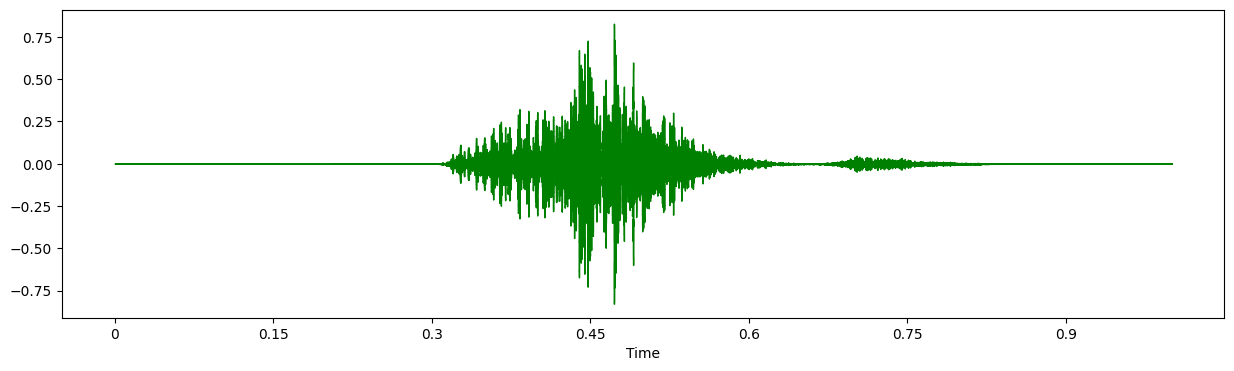

In [189]:
plt.figure(figsize=(15, 4))
librosa.display.waveshow(Y[5071], x_axis = "time", color = 'green')
plt.show()

# Randomizing the data

In [190]:
import pandas as pd
df = pd.DataFrame(data=Y)
df['label'] = labels
df = df.sample(frac=1).reset_index(drop=True)

In [191]:
# again convert the dataframe to numpy array
Y = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values

In [192]:
import IPython.display as ipd
ipd.Audio(Y[4957], rate=sr)

# Getting the spectrogram

In [193]:
X = np.array([librosa.stft(ele) for ele in Y])

In [194]:
Xdb = np.array([librosa.amplitude_to_db(abs(ele)) for ele in X])

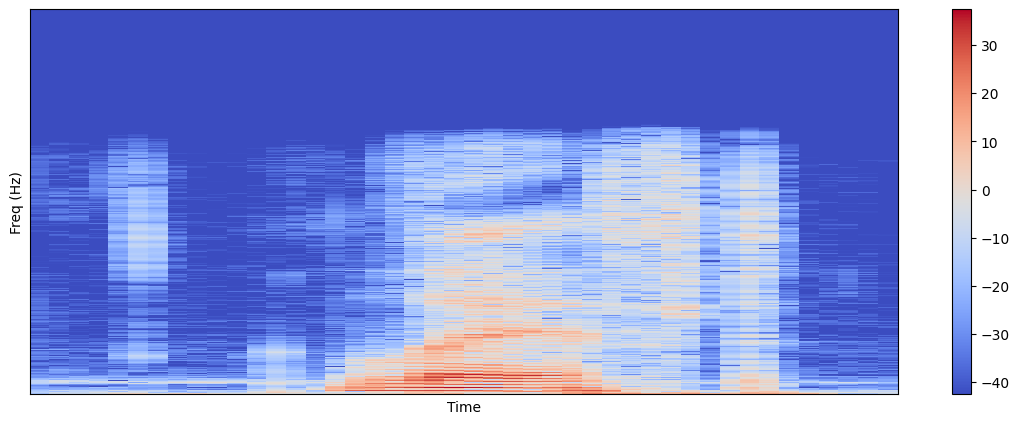

In [195]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb[501], sr=sr)
plt.colorbar()
plt.xlabel("Time")
plt.ylabel("Freq (Hz)")
plt.show()

# Getting the MFCCs

In [196]:
MFCCs = np.array([librosa.feature.mfcc(y=ele, sr=sr) for ele in Y])

In [197]:
MFCCs.shape

(16000, 20, 44)

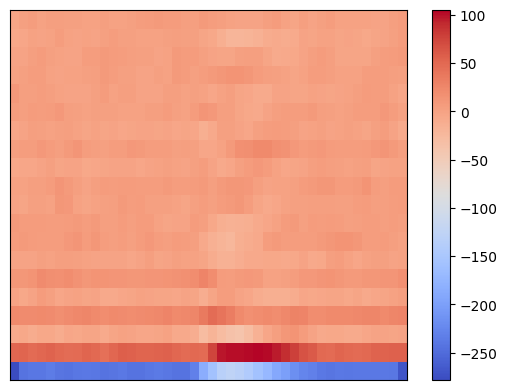

In [198]:
librosa.display.specshow(MFCCs[606], sr=sr)
plt.colorbar()
plt.show()

# Making the model

In [201]:
MFCCs.reshape(16000, 20, 44, 1)
num_samples = 8000
num_mfccs = 20
num_frames = 44
num_classes = 8

model = Sequential()
model.add(InputLayer(input_shape=(num_mfccs, num_frames, 1)))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 20, 44, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 22, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 11, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 11, 128)        73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 5, 128)        

In [202]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [203]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [204]:
one_hot_encoder = OneHotEncoder(sparse=False, categories='auto')
one_hot_labels = one_hot_encoder.fit_transform(encoded_labels.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [205]:
history = model.fit(MFCCs, one_hot_labels, epochs=10, validation_split=0.2)

Epoch 1/10
400/400 [==============================] - 5s 11ms/step - loss: 2.1293 - accuracy: 0.1959 - val_loss: 1.5469 - val_accuracy: 0.3550
Epoch 2/10
400/400 [==============================] - 4s 10ms/step - loss: 1.3297 - accuracy: 0.4673 - val_loss: 0.8002 - val_accuracy: 0.6775
Epoch 3/10
400/400 [==============================] - 4s 11ms/step - loss: 0.7126 - accuracy: 0.7409 - val_loss: 0.3978 - val_accuracy: 0.8584
Epoch 4/10
400/400 [==============================] - 4s 11ms/step - loss: 0.4171 - accuracy: 0.8559 - val_loss: 0.2793 - val_accuracy: 0.8991
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2993 - accuracy: 0.8969 - val_loss: 0.2475 - val_accuracy: 0.9109
Epoch 6/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2405 - accuracy: 0.9195 - val_loss: 0.2107 - val_accuracy: 0.9297
Epoch 7/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2086 - accuracy: 0.9309 - val_loss: 0.1942 - val_accuracy: 0.9384

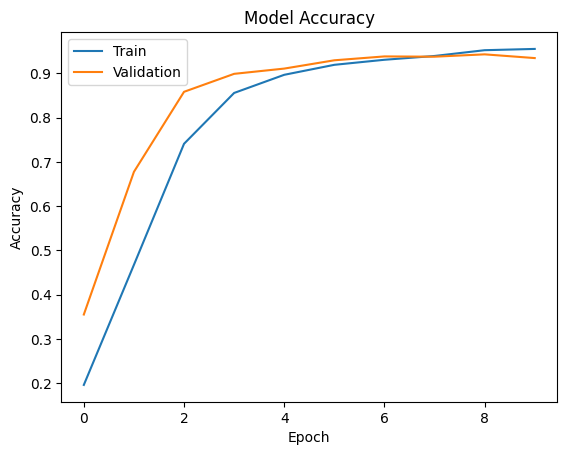

In [206]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()